<a href="https://colab.research.google.com/github/IzadoraSC/spectral_index/blob/main/Indices_Espectrais_v01_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ÍNDICES DE ESPECTRAIS
1. Obtenção dos dados (utilizando GEE):
  - Selecionar área de estudo;
  - Obtendo dados multiespectrais;
  - Índices espectrais;
  - Temperatura de Superfície;
  - Exportação dos dados.

2. Extração de dados por ponto;
  
3. Análises: Correlação, PCA, etc.;

4. Referências.

Script By: Izadora S. de Carvalho.

Paper: Izadora S. de Carvalho, Swanni T. Alvarado, Patrick Costa Silva, Leo Leonel, Aline Silva, Tiago Massi Ferraz.

Obs: O código pode ser aplicado para outras áreas de estudos, estamos aberto a colaborações e sugestões.

Contato: izadoraflorestal@gmail.com / izadorasccs@gmail.com

Repositório para disponibilização e manutenção de código: [Github](https://github.com/IzadoraSC/spectral_index/tree/main)

##Conectando Drive

In [23]:
# Conectando Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1   Obtendo dados do Google Earth Engine (GEE).
Obtendo as imagens/rasters que serão utilizados nas etapas de geração dos Índices Espectrais:
  - Dados Landsat
  - Dados Sentinel
---

### Instalando bibliotecas

In [2]:
# Instalando bibliotecas
!pip install spyndex -q
!pip install spectral -q
!pip install rasterio -q
!pip install matplotlib-scalebar -q
!pip install cartopy -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.7/728.7 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 110.4 MB/s eta 0:00:00


### Importar as bibliotecas

In [3]:
#Importando bibliotecas

#GEE
import ee
import geemap

#Indices
import spyndex
import xarray as xr
import matplotlib.pyplot as plt
from rasterio import plot
import rasterio as rio
import pandas as pd
import seaborn as sns
import numpy as np
import dask.array as da


import spectral
import eemont
import geemap
import geemap.colormaps as cm


#Outras
import json
import geopandas as gpd
import os
#import geobr
import altair as alt ##biblioteca de visualização(gráficos)

# Plotando figura dos índices
from matplotlib.colors import Normalize
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrowPatch, Rectangle
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Autenticação da conta do GEE

In [7]:
# Autenticação padrão da conta do GEE
ee.Authenticate()
ee.Initialize(project='ee-izadorasc')  ## 'project' é individual para cada usuário


### Usando geobr (para quando necessitar acessar base de dados do IBGE)

- Diversos arquivos vetoriais disponíveis

In [ ]:
# Lendo vetor do PNCM usando geobr

UCs = geobr.read_conservation_units()
UCs
#BR = geobr.read_country()
#BR
#BR.plot()

In [ ]:
# Selecionando área de interesse
list_of_names = ['PARQUE NACIONAL DA CHAPADA DAS MESAS']
pncm_df = UCs.query('name_conservation_unit in @list_of_names')
pncm_df

In [ ]:
MA = geobr.read_state(code_state='MA', year=2020)
MA

In [ ]:
MA.plot()

In [ ]:
pncm_df.plot()

In [ ]:
#Conversão de geodataframe para json
pncm_json = pncm_df.to_json()

#Carregando o arquivo
pncm_json_coords = json.loads(pncm_json)

# Selecionando coordenadas
pncm_coord = pncm_json_coords['features']

In [ ]:
print(pncm_json_coords)

In [ ]:
pncm_coord

In [ ]:
# Convertendo para FeatureCollection
aoi = ee.FeatureCollection(pncm_coord)

### **Data Image**

#### **Informações sobre os sensores e outras**

In [ ]:
# Reflectância de Superficíe

########### LANDSAT ##############

# Landsat 4 TM (Aug 22, 1982 - Jun 24, 1993)
  # USGS Landsat 4 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT04/C02/T1_L2"

# Landsat 5 TM (Mar 16, 1984 - May 05, 2012)
  # USGS Landsat 5 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LT05/C02/T1_L2"

# Landsat 7 ETM+ (May 28, 1999 - Jul 15, 2023)
  # USGS Landsat 7 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LE07/C02/T1_L2"

# Landsat 8 OLI (Mar 18, 2013 - present)
  # USGS Landsat 8 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC08/C02/T1_L2"

# Landsat 9 OLI (Out 31, 2021 - present)
  # USGS Landsat 9 Level 2, Collection 2, Tier 1
  # sensor = "LANDSAT/LC09/C02/T1_L2"

# scale factor = 2.75e-05
# scale factor surface temperature = 0.00341802

################## SENTINEL ########################

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-1C (Jun 27, 2015 - present)
#Top-of-Atmosphere Reflectance
#ee.ImageCollection("COPERNICUS/S2_HARMONIZED")
# https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_HARMONIZED

# sensor = "COPERNICUS/S2_HARMONIZED"

# Harmonized Sentinel-2 MSI: MultiSpectral Instrument, Level-2A (Mar 28, 2017 - present)
# Surface Reflectance
#ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
#https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED

# sensor = "COPERNICUS/S2_SR_HARMONIZED"

##########################################
# Julian days
# jan = [1,31,'day_of_year'];
# fev = [32,59,'day_of_year'];
# mar = [60,90,'day_of_year'];
# abr = [91,120,'day_of_year'];
# may = [121,151,'day_of_year'];
# jun = [152,181,'day_of_year'];
# jul = [182,212,'day_of_year'];
# ago = [213,243,'day_of_year'];
# set = [244,273,'day_of_year'];
# out = [274,304,'day_of_year'];
# nov = [304,334,'day_of_year'];
# dez = [335,365,'day_of_year'];

############################################
# Alguns formatos de dados
# .toDouble()  #64-bit float
# .toFloat()  #32-bit float
# .toInt16()  # signed 16-bit integer
# .toInt32() # signed 32-bit integer
# .toUint16() # unsigned 16-bit integer

####Visualização dos dados:
  - Construindo paletas de cores.

In [8]:
#Visualização dos dados

#LANDSAT
VisLS457_falseColor = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B5', 'SR_B4', 'SR_B3']}

VisLS89_falseColor = {
  'min': 0,
  'max': 0.3,
  'gamma': 1,
  'opacity': 1,
  'bands': ['SR_B6', 'SR_B5', 'SR_B4']}

VisLS89_trueColor = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1,
    'opacity': 1,
    'bands': ['SR_B4', 'SR_B3', 'SR_B2']}

#SENTINEL
VisS2 = {
  'min': 0.0,
  'max': 0.3,
  'gamma': 1.1,
  'bands': ['B4', 'B3', 'B2']}


# ÍNDICES

##Colors map
visNDVI = cm.palettes.ndvi
##Definindo os parâmetros
vis_NDVI = {
  'min': 0,
  'max': 1,
  'palette': visNDVI}

VisNDVI = {
  'min': 0,
  'max': 1,
  'palette': ['FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718',
               '74A901', '66A000', '529400', '3E8601', '207401', '056201',
               '004C00', '023B01', '012E01', '011D01', '011301']
  }

##Definindo os parâmetros
VisNDWI = {
    'bands': ['NDWI'],
    'palette': ['#ece7f2', '#d0d1e6', ' #a6bddb', ' #74a9cf', ' #3690c0', ' #0570b0', ' #045a8d', '#023858'],
    'min': -0.7546916749172777,
    'max': -0.27315915803905233,
    'opacity': 1.0,
    'gamma': 1.0}

# '#ece7f2', '#d0d1e6', ' #a6bddb', ' #74a9cf', ' #3690c0', ' #0570b0', ' #045a8d', '#023858'
# VisNDWI = {
#   'min': 0,
#   'max': 1,
#   'palette': cm.palettes.ndwi}

# VisNDWI = {
#   'min': -1,
#   'max': 0.5,
#   'palette': ['red', 'yellow', 'green', 'blue']
#   }

#### **Máscara de Nuvens**
- Landsat - TM, OLI
- Sentinel 2 - MSI

In [9]:
## Landsat 4, 5, 7, 8 and 9 for SR data
def maskLSclouds(image):

  # Os bits 3 e 5 são a sombra da nuvem e a nuvem, respetivamente, para os produtos Landsat 4-5-7-8 e 9 SR
  # Aqui definimos os valores dos bits em valores de bytes.

# Criando uma função para mascarar pixéis de nuvens e sombras de nuvens
# 1 corresponde a céu limpo
# 3 corresponde a sombra de nuvem
# 5 corresponde a nuvem

  #cloudShadowBitMask = ee.Number(1).pow(3).int()
  #cloudsBitMask = ee.Number(1).pow(5).int()
  qaMask = image.select('QA_PIXEL').bitwise_and(int('11111', 2)).eq(0)
  saturationMask = image.select('QA_RADSAT').eq(0)

  # Obter a banda de pixel QA da coleção.
  #qa = image.select('QA_PIXEL')

  ###Fator de escala
  #opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)

  ###Fator de escala
  opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
  thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)

  ##Produto resultante
  return image.addBands(opticalBands, None, True)\
  .addBands(thermalBands, None, True).updateMask(qaMask)\
  .updateMask(saturationMask)

  # Se esse processo não for realizado, não podemos filtrar por data depois.
  #return image.updateMask(mask.copyProperties(image,["system:time_start"]))

In [8]:
##Máscara de nuvens
def maskS2clouds(image):
    qa = image.select('QA60')

    # Bits 10 and 11 are clouds and cirrus, respectively.
    #cloudBitMask = int(2**10)
    #cirrusBitMask = int(2**11)
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(\
           qa.bitwiseAnd(cirrusBitMask).eq(0))

    # clouds is not clear
    # cloud = mask.Not().rename(['QA60'])

    # return the masked and scaled data.
    return image.updateMask(mask).divide(10000)

#### **Área de estudo**

In [10]:
## Árae de estudo
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

ROI = ee.Geometry.Rectangle([-47.48, -6.85, -46.70, -7.42])
#ROI2 = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")
ROI = ee.FeatureCollection("projects/ee-izadorasc/assets/limite_pncm")

Map.addLayer(ROI, {'color': 'black'}, 'Limite PNCM')

Map

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [11]:
## Pontos amostrais de campo
plotPoints = ee.FeatureCollection("projects/ee-izadorasc/assets/plots_1m")

Map.addLayer(plotPoints, {'color': 'red'}, 'Pontos amostrais')

#### **Definindo Sensor e Data**

In [44]:
#Definindo a coleção do sensor Landsat que será utilizado
#sensor = "LANDSAT/LT05/C02/T1_L2"
#sensor = "LANDSAT/LE07/C02/T1_L2"
sensor = "LANDSAT/LC08/C02/T1_L2"  ## para dados de out/2022
# sensor = "LANDSAT/LC09/C02/T1_L2"  ## para dados de julho/2022

#sensor = "COPERNICUS/S2_SR_HARMONIZED"

###Definição de entradas - Período de interesse
# start_date = '2022-06-25'
# end_date = '2022-07-13'
#sentinel
#start_date = '2022-07-05'
#end_date = '2022-07-07'

start_date = '2022-10-01'
end_date = '2022-10-31'
#date_range = ['2022-01-01', '2022-12-31']

#### **Imagens Landsat**

In [47]:
# imageLS = ee.ImageCollection(sensor).filterBounds(region)\
#                                       .filterDate(start, end)\
#                  .filter(ee.Filter.lt('CLOUD_COVER', 80))\
#                                                  .map(maskL8sr)\
#                                                  .select(['SR_B.*', 'ST_B.*'])

# imageLS

# Load Landsat surface reflectance data
LS_collection = ee.ImageCollection(sensor) \
    .filterBounds(ROI)\
    .filter(ee.Filter.lt('CLOUD_COVER', 45))\
    .filterDate(start_date, end_date)

# Map the maskLSclouds function over each seasonal dataset and take the median of clear pixels.
img_comp = LS_collection.map(maskLSclouds).median()

# Clip the composite images to the Region of Interest
clip_ls_comp = img_comp.clip(ROI)

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# Add the wet and dry season composites to the map

# LS4 LS5 and LS7
# Map.addLayer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# Map.addLayer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
Map.addLayer(clip_ls_comp, VisLS89_falseColor, 'LS - Falsa Cor')
Map.addLayer(clip_ls_comp, VisLS89_trueColor, 'LS - Cor Verdadeira')
# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [48]:
#Verificando cenas da coleção
LS_collection

In [38]:
## Verificando as bandas
bandas = clip_ls_comp.bandNames()
bandas

In [49]:
## Banda termal
imageTermal = clip_ls_comp.select(['ST_B.*']) #selecionando somente a banda do termal
#imageTermal

## Verificando a banda
bandaTermal = imageTermal.bandNames()
bandaTermal

In [17]:
## Visualizando banda termal
Map.addLayer(imageTermal, {'bands': ['ST_B10'], 'min': 303.85, 'max': 321.47, 'palette' : ['blue', 'green', 'yellow', 'red']}, 'Termal')
Map

Map(bottom=136581.0, center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], …

#### **Sentinel 2**

In [ ]:
##Selecionar imagens da coleção
S2_collection = ee.ImageCollection(sensor)\
                              .filterBounds(ROI)\
                              .filter(ee.Filter.date(start_date, end_date))\
                              .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',30))

# Map the maskLSclouds function over each seasonal dataset and take the median of clear pixels.
imgS2_comp = S2_collection.map(maskS2clouds).median()

# Clip the composite images to the Region of Interest
clip_s2_comp = imgS2_comp.clip(ROI)

# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

# Add the wet and dry season composites to the map

# LS4 LS5 and LS7
# Map.addLayer(clip_wet_comp, paletteVisLS457, 'Wet_composite')
# Map.addLayer(clip_dry_comp, paletteVisLS457, 'Dry_composite')

# LS8 and LS9
Map.addLayer(clip_s2_comp, VisS2, 'S2')

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.

Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [ ]:
S2_collection

Name,Description
B1,Aerosols
B2,Blue
B3,Green
B4,Red
B5,Red Edge 1
B6,Red Edge 2
B7,Red Edge 3
B8,NIR
B8A,Red Edge 4
B9,Water vapor


In [ ]:
## Verificando as bandas
bandas_S2 = clip_s2_comp.bandNames()
bandas_S2

#####Download

In [ ]:
#region= ROI.getInfo()["coordinates"]
task = ee.batch.Export.image.toDrive(
            image= clip_s2_comp.select('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A',
                                       'B11', 'B12'),
            description= "s2_PNCM_06072022",
            folder= "00_vegetation_data",
            region=ROI.geometry(), # conversão necessária para recortar o raster de saída
            scale= 10, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

### **Índices Espectrais**

In [18]:
# Open a dataset (in this case a xarray.DataArray)
#Sentinel
#snt = ("/content/drive/MyDrive/00_vegetation_data/s2_PNCM_06072022.tif")
#Landsat
# img = ("/content/drive/MyDrive/00_vegetation_data/LS9_05072022_index.tif")
# img

'/content/drive/MyDrive/00_vegetation_data/LS9_05072022_indicesTemp.tif'

In [50]:
#Landsat
clip_ls_comp.getInfo()
img = clip_ls_comp
img
#Sentinel
# clip_s2_comp.getInfo()
# img = clip_s2_comp



In [ ]:
# Visualizar índices
spyndex.indices

In [51]:
bandNames = ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7']
newBandNames = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7'];
# ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
# Renomear as bandas
img = img.select(bandNames).rename(newBandNames);
img

In [52]:
idx = spyndex.computeIndex(
    index = ["EVI","GNDVI", "MCARI1",'MNDWI','MSAVI','NDMI',"NDVI", 'NDWI',
             'SAVI', 'SLAVI'],
    params = {
        "R": img["B4"],
        "G": img["B3"],
        "B": img["B2"],
        "N": img["B5"],
        "S1": img["B6"],
        "S2": img["B7"],
        "g": 2.5,
        "C1": 6,
        "C2": 7.5,
        "L": 0.5
    }
)

In [150]:
# Formulas
# spyndex.indices.MCARI1.formula
# spyndex.indices.MNDWI.formula
# spyndex.indices.NDVI.formula
# spyndex.indices.NDMI.formula
# spyndex.indices.SAVI.formula
spyndex.indices.SLAVI.formula


'N/(R+S2)'

In [157]:
# Referencias
# spyndex.indices.MCARI1.reference
# spyndex.indices.MNDWI.reference
# spyndex.indices.NDVI.reference
# spyndex.indices.NDMI.reference
# spyndex.indices.SAVI.reference
spyndex.indices.SLAVI.reference

'https://www.asprs.org/wp-content/uploads/pers/2000journal/february/2000_feb_183-191.pdf'

In [53]:
img = img.addBands(idx)
img

In [54]:
img.bandNames().getInfo()

['B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'EVI',
 'GNDVI',
 'MCARI1',
 'MNDWI',
 'MSAVI',
 'NDMI',
 'NDVI',
 'NDWI',
 'SAVI',
 'SLAVI']

####Download Imagem - Índices

In [55]:
#region= ROI.getInfo()["coordinates"]
#Landsat
task = ee.batch.Export.image.toDrive(
            # image= img.select('EVI','GNDVI','MCARI1','MNDWI','MSAVI',
            #                   'NDMI','NDVI','NDWI','SAVI','SLAVI'),
            image= img.select('MCARI1','MNDWI','NDMI','NDVI','SAVI','SLAVI'),
            #description= "LS8_17102022_indicesTemp",
            description= "LS8_17102022_index6",
            # description= "LS9_05072022_index6",
            folder= "00_vegetation_data",
            region=ROI.geometry(), # conversão necessária para recortar o raster de saída
            scale= 30, ## tamanho do pixel em metros
            crs= "EPSG:4326", #WGS84 - World Geodetic System 1984
            fileFormat= "GeoTIFF",
            maxPixels= 5000000000) # Definir um valor muito grande para garantir que toda a imagem seja exportada

task.start()

####Extraindo dados das parcelas de campo

In [56]:
image1 = img.select('MCARI1','MNDWI','NDMI','NDVI','SAVI','SLAVI')
image1

In [57]:
## Pontos amostrais de campo
##Extrair valores de índices a partir dos pontos das parcelas de campo
extract_bands = image1.sampleRegions(
  collection= plotPoints,
  scale= 30,
  geometries=True
  # 'properties': ['MCARI1','MNDWI','NDMI','NDVI','SAVI','SLAVI']
);

extract_bands

In [58]:
##Labels das bandas utilizadas

labels =['id', 'name','lat', 'long', 'MCARI1','MNDWI','NDMI','NDVI','SAVI','SLAVI']
##Crie uma lista com os dados da malha amostra que você criou
Lista_df = extract_bands.reduceColumns(ee.Reducer.toList(10), labels).values().get(0)
##Visualize seu dataframe no utilizando os pandas
df = pd.DataFrame(Lista_df.getInfo(), columns=labels)
df

,id,name,lat,long,MCARI1,MNDWI,NDMI,NDVI,SAVI,SLAVI
0,29,WSL3P1,-7.2699,-47.0324,0.244413,-0.595689,-0.050005,0.498930,0.319820,1.034090
1,30,WSL3P2,-7.2700,-47.0322,0.229782,-0.592275,-0.054858,0.476317,0.307994,0.999482
2,31,WSL3P3,-7.2700,-47.0323,0.229782,-0.592275,-0.054858,0.476317,0.307994,0.999482
3,32,WSL3P4,-7.2700,-47.0324,0.229782,-0.592275,-0.054858,0.476317,0.307994,0.999482
4,10,OSL2P2,-7.3183,-47.0615,0.153295,-0.493458,-0.076054,0.313762,0.229796,0.693626
5,9,OSL2P1,-7.3184,-47.0614,0.164927,-0.518431,-0.091955,0.331445,0.240551,0.693811
6,12,OSL2P4,-7.3184,-47.0616,0.125737,-0.484396,-0.113717,0.266095,0.203492,0.614304
7,11,OSL2P3,-7.3185,-47.0615,0.164927,-0.518431,-0.091955,0.331445,0.240551,0.693811
8,2,OSL1P2,-7.3205,-47.0568,0.162657,-0.542356,-0.118552,0.319215,0.242849,0.702801
9,1,OSL1P1,-7.3206,-47.0567,0.176665,-0.533607,-0.117441,0.329112,0.248068,0.708293


In [59]:
##Exportar dados csv das amostras
# df.to_csv('/content/drive/MyDrive/00_vegetation_data/pts_index_value_jul.csv')
df.to_csv('/content/drive/MyDrive/00_vegetation_data/pts_index_value_out.csv')

####Visualizando índices

#####Paleta de cores

In [ ]:
cm.palettes.spectral

In [61]:
VisLStrue = {
    'min': 0.0,
    'max': 0.3,
    'gamma': 1,
    'opacity': 1,
    'bands': ['B4', 'B3', 'B2']}

VisNDWI = {
  'min': 0,
  'max': 1,
  'palette': cm.palettes.ndwi}

#####Plotando - geemap

In [175]:
# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

Map.addLayer(img, VisLStrue, 'LS')
# Map.addLayer(idx['EVI'],{'min': 0.1,'max': 0.7,"palette":cm.palettes.ndvi},"EVI")
# Map.addLayer(idx["GNDVI"],{'min': 0.3,'max': 0.8,"palette":cm.palettes.ndvi},"GNDVI")
Map.addLayer(idx['MCARI1'],{'min': 0.05,'max': 0.40,"palette":cm.palettes.ndvi},'MCARI1')
Map.addLayer(idx['MNDWI'],{'min': -0.72,'max': -0.45,"palette":cm.palettes.ndvi},'MNDWI')
# Map.addLayer(idx['MSAVI'],{'min': 0.1,'max': 0.4,"palette":cm.palettes.ndvi},'MSAVI')
Map.addLayer(idx['NDMI'],{'min': -0.3,'max': 0.3,"palette":cm.palettes.ndvi},'NDMI')
Map.addLayer(idx["NDVI"],{'min': 0.1,'max': 0.9,"palette":cm.palettes.ndvi},"NDVI")
# Map.addLayer(idx["NDWI"],{'min': -0.8,'max': -0.3,"palette":cm.palettes.ndvi},"NDWI")
Map.addLayer(idx['SAVI'],{'min': 0.1,'max': 0.5,"palette":cm.palettes.ndvi},'SAVI')
Map.addLayer(idx['SLAVI'],{'min': -0.7,'max': 2,"palette":cm.palettes.ndvi},'SLAVI')

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.


Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

In [66]:
# Display composite results using geemap
Map = geemap.Map(center=[-7.135, -47.09], zoom=10)

Map.addLayer(img, VisLStrue, 'LS-Out')
Map.addLayer(idx['MCARI1'],{'min': 0.0,'max': 0.4,"palette":cm.palettes.ndvi},'MCARI1-Out')
Map.addLayer(idx['MNDWI'],{'min': -0.7,'max': -0.3,"palette":cm.palettes.ndvi},'MNDWI-Out')
Map.addLayer(idx['NDMI'],{'min': -0.3,'max': 0.2,"palette":cm.palettes.ndvi},'NDMI-Out')
Map.addLayer(idx["NDVI"],{'min': 0.1,'max': 0.8,"palette":cm.palettes.ndvi},"NDVI-Out")
Map.addLayer(idx['SAVI'],{'min': 0.1,'max': 0.5,"palette":cm.palettes.ndvi},'SAVI-Out')
Map.addLayer(idx['SLAVI'],{'min': 0.1,'max': 1.8,"palette":cm.palettes.ndvi},'SLAVI-Out')

# Display the map
Map.addLayerControl()
Map  # This will display the map in the Jupyter notebook.


Map(center=[-7.135, -47.09], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchData…

#####Plotando - Matplotlib

In [70]:
ls_img = ("/content/drive/MyDrive/00_vegetation_data/LS9_05072022_index6.tif")
# ls_img = ("/content/drive/MyDrive/00_vegetation_data/LS8_17102022_index6.tif")
ls_img

'/content/drive/MyDrive/00_vegetation_data/LS9_05072022_index6.tif'

In [71]:
# Conferindo dado raster
with rio.open(ls_img) as src:
    img2 = src.read()
    meta = src.meta
    profile = src.profile

img2 = img2.transpose([1,2,0])

print(img2.shape)
print(meta)
print(profile)


(1754, 2516, 6)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2516, 'height': 1754, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -47.42269266936843,
       0.0, -0.00026949458523585647, -6.892054522821794)}
{'driver': 'GTiff', 'dtype': 'float64', 'nodata': None, 'width': 2516, 'height': 1754, 'count': 6, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.00026949458523585647, 0.0, -47.42269266936843,
       0.0, -0.00026949458523585647, -6.892054522821794), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}


In [ ]:
# 1 = 'EVI', # 2 = 'GNDVI', # 3 = 'MCARI1', # 4 = 'MNDWI', # 5 = 'MSAVI',
# 6 = 'NDMI', # 7 = 'NDVI', # 8 = 'NDWI', # 9 = 'SAVI', # 10 = 'SLAVI'

# 1 = 'MCARI1', # 2 = 'MNDWI', # 3 = 'NDMI', # 4 = 'NDVI', # 5 = 'SAVI', # 6 = 'SLAVI'

<Axes: title={'center': 'SLAVI'}>

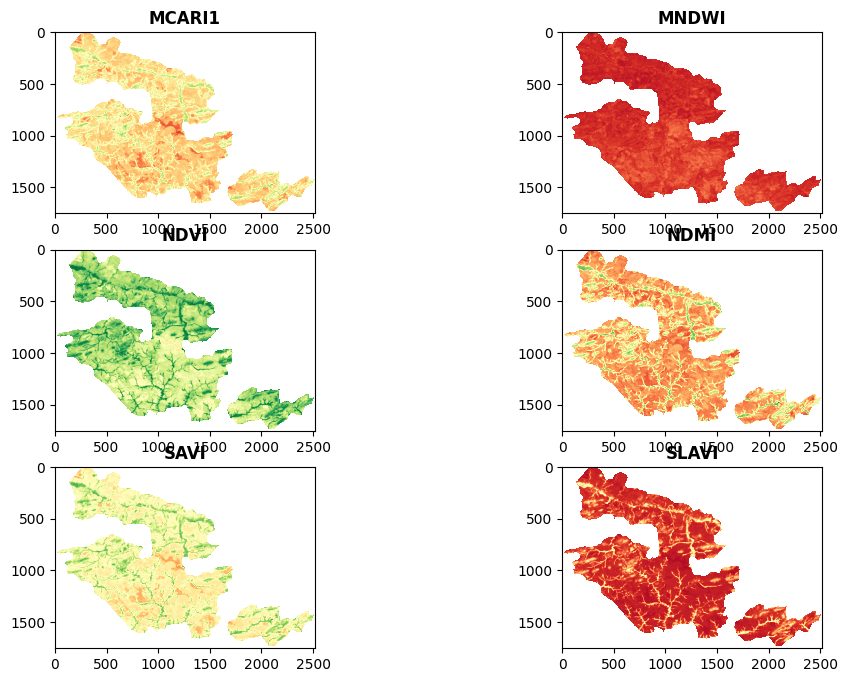

In [182]:
# Plot the indices (and the RGB image for comparison)
fig, ax = plt.subplots(3,2,figsize = (12,8))
# plot.show(img2[:,:,0],ax = ax[0,0],cmap='RdYlGn',title = "EVI")
# plot.show(img2[:,:,1],ax = ax[0,1],cmap='RdYlGn', title = "GNDVI")
# plot.show(img2[:,:,2],ax = ax[0,0],cmap='RdYlGn', title = "MCARI1")
# plot.show(img2[:,:,3],ax = ax[0,1],cmap='RdYlGn', title = "MNDWI")
# # plot.show(img2[:,:,4],ax = ax[2,0],cmap='RdYlGn', title = "MSAVI")
# plot.show(img2[:,:,5],ax = ax[1,1],cmap='RdYlGn', title = "NDMI")
# plot.show(img2[:,:,6],ax = ax[1,0],cmap='RdYlGn', title = "NDVI")
# # plot.show(img2[:,:,7],ax = ax[3,1],cmap='RdYlGn', title = "NDWI")
# plot.show(img2[:,:,8],ax = ax[2,0],cmap='RdYlGn', title = "SAVI")
# plot.show(img2[:,:,9],ax = ax[2,1],cmap='RdYlGn', title = "SLAVI")

plot.show(img2[:,:,0],ax = ax[0,0],cmap='RdYlGn', title = "MCARI1")
plot.show(img2[:,:,1],ax = ax[0,1],cmap='RdYlGn', title = "MNDWI")
plot.show(img2[:,:,2],ax = ax[1,1],cmap='RdYlGn', title = "NDMI")
plot.show(img2[:,:,3],ax = ax[1,0],cmap='RdYlGn', title = "NDVI")
plot.show(img2[:,:,4],ax = ax[2,0],cmap='RdYlGn', title = "SAVI")
plot.show(img2[:,:,5],ax = ax[2,1],cmap='RdYlGn', title = "SLAVI")

In [72]:
# Adicionar a escala norte
def add_north_arrow(ax, location=(0.1, 0.9), size=20, color='black'):
    ax.annotate('',
                xy=location,
                xytext=(location[0], location[1] + 0.05),
                arrowprops=dict(facecolor=color, edgecolor=color, width=5, headwidth=10),
                ha='center', va='center', fontsize=size, color=color)

# Cores específicas para cada índice
# colormaps = {
#     # 'EVI': 'RdYlGn',
#     # 'GNDVI': 'BrBG',
#     # 'GNDVI': 'RdYlGn',
#     'MCARI1': 'PiYG',
#     'MNDWI': 'Blues',
#     # 'MSAVI': 'YlGn',
#     # 'MSAVI': 'YlOrBr',
#     'NDMI': 'RdYlBu',
#     # 'NDVI': 'Greens',
#     'NDVI': 'RdYlGn',
#     #'NDWI': 'BuGn',
#     # 'NDWI': 'Blues',
#     'SAVI': 'YlOrBr',
#     # 'SLAVI': 'Oranges',
#     'SLAVI': 'Greens'
# }
colormaps = {
    'MCARI1': 'PiYG',
    'MNDWI': 'Blues',
    'NDMI': 'RdYlBu',
    'NDVI': 'RdYlGn',
    'SAVI': 'YlOrBr',
    'SLAVI': 'Greens'
}
# Valores mínimo e máximo para normalização de cada índice
# index_ranges = {
#     # 'EVI': (0.1, 0.7),
#     # 'GNDVI': (0.3, 0.8),
#     'MCARI1': (0.05, 0.4),
#     'MNDWI': (-0.72, -0.45),
#     # 'MSAVI': (0.1, 0.4),
#     'NDMI': (-0.3, 0.3),
#     'NDVI': (0.1, 0.9),
#     # 'NDWI': (-0.8, -0.3),
#     'SAVI': (0.1, 0.5),
#     'SLAVI': (-0.7, 2.0)
# }

index_ranges = {
    'MCARI1': (0.05, 0.4),
    'MNDWI': (-0.72, -0.45),
    'NDMI': (-0.3, 0.3),
    'NDVI': (0.1, 0.9),
    'SAVI': (0.1, 0.5),
    'SLAVI': (-0.7, 2.0)
}

# index_ranges = {
#     'MCARI1': (0.0, 0.4),
#     'MNDWI': (-0.7, -0.3),
#     'NDMI': (-0.3, 0.2),
#     'NDVI': (0.1, 0.8),
#     'SAVI': (0.1, 0.5),
#     'SLAVI': (0.1, 1.8)
# }
# Índices e títulos
# indices = ['EVI', 'GNDVI', 'MCARI1', 'MNDWI', 'MSAVI', 'NDMI', 'NDVI', 'NDWI', 'SAVI', 'SLAVI']
indices = ['MCARI1', 'MNDWI', 'NDMI', 'NDVI', 'SAVI', 'SLAVI']


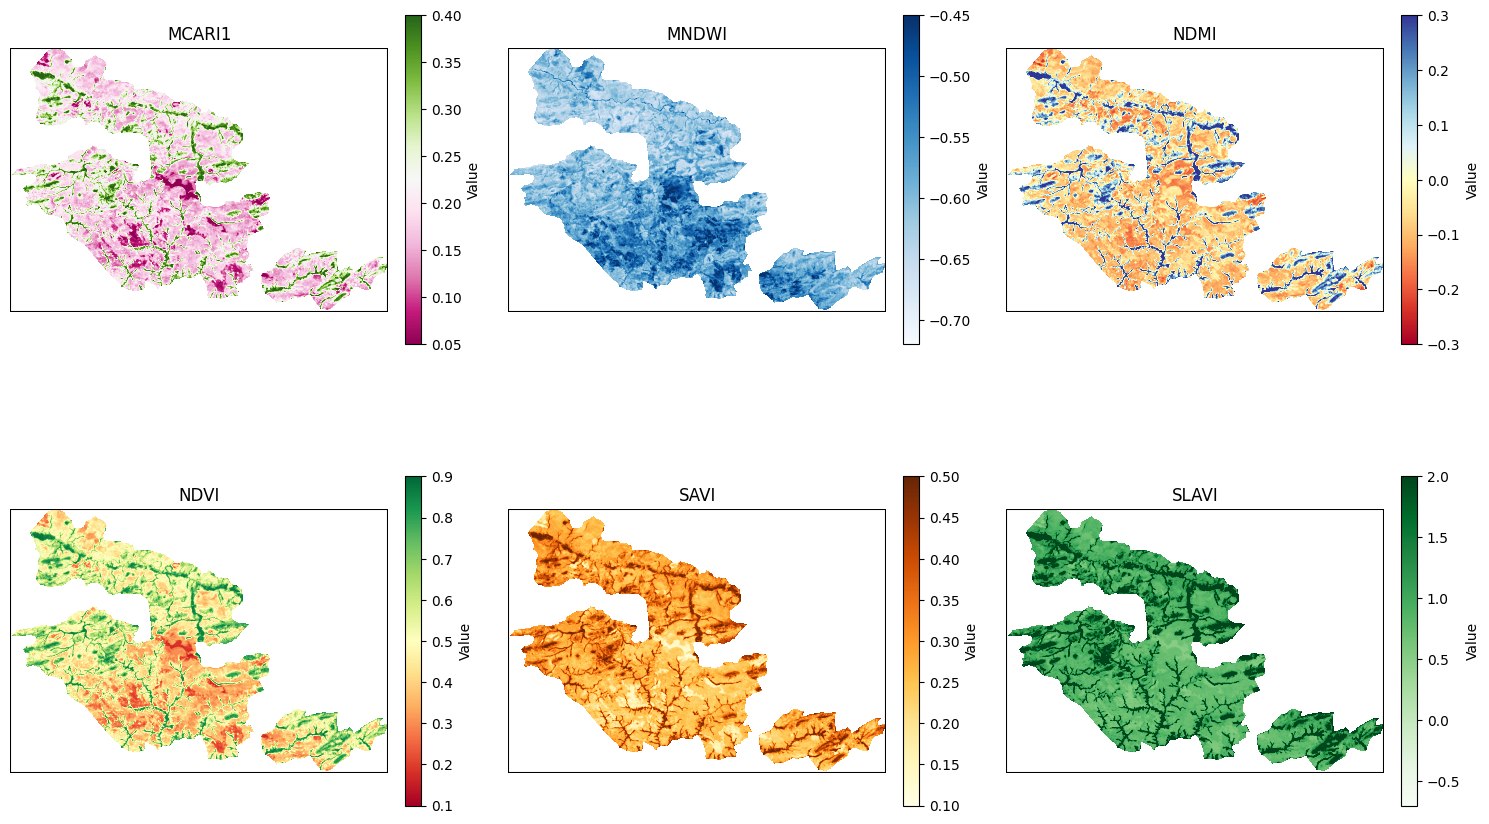

In [73]:
# JULHO/2022
#sub_img_bbox = [-47.5, -46.7, -7.4, -6.9] #xmin, xmax, ymin, ymax
# sub_img_bbox = [-47.3, -47.0, -7.2, -6.9]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ax, index) in enumerate(zip(axes, indices[:6])):  # Ajustado para 2x3 subplots
    cmap = colormaps[index]
    vmin, vmax = index_ranges[index]
    norm = Normalize(vmin=vmin, vmax=vmax)
    # bbox=sub_img_bbox

    img = ax.imshow(img2[:, :, idx], cmap=cmap, norm=norm)
    ax.set_title(index)
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.040, pad=0.04)
    cbar.ax.set_ylabel('Value')

    # add_north_arrow(ax, location=(0.1, 0.9))
    ax.axis('off')

    # Adicionar contorno ao redor da figura plotada
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

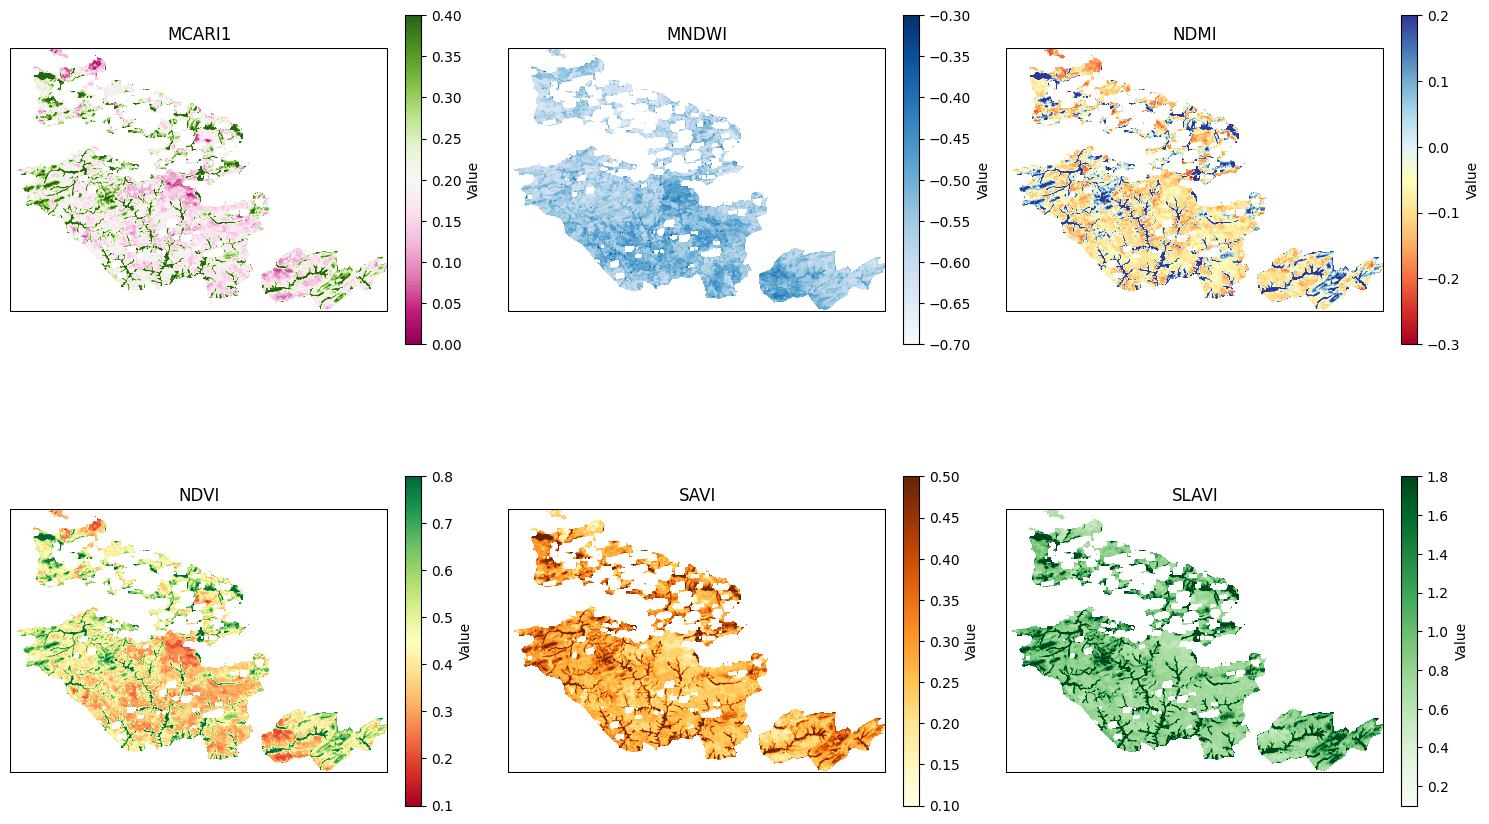

In [69]:
# OUTUBRO/2022
#sub_img_bbox = [-47.5, -46.7, -7.4, -6.9] #xmin, xmax, ymin, ymax
# sub_img_bbox = [-47.3, -47.0, -7.2, -6.9]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, (ax, index) in enumerate(zip(axes, indices[:6])):  # Ajustado para 2x3 subplots
    cmap = colormaps[index]
    vmin, vmax = index_ranges[index]
    norm = Normalize(vmin=vmin, vmax=vmax)
    # bbox=sub_img_bbox

    img = ax.imshow(img2[:, :, idx], cmap=cmap, norm=norm)
    ax.set_title(index)
    cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.040, pad=0.04)
    cbar.ax.set_ylabel('Value')

    # add_north_arrow(ax, location=(0.1, 0.9))
    ax.axis('off')

    # Adicionar contorno ao redor da figura plotada
    rect = Rectangle((0, 0), 1, 1, transform=ax.transAxes,
                     edgecolor='black', facecolor='none', linewidth=1.5)
    ax.add_patch(rect)

plt.tight_layout()
plt.show()

In [ ]:
# fig, axes = plt.subplots(2, 3, figsize=(15, 20), subplot_kw={'projection': ccrs.PlateCarree()})
# axes = axes.flatten()

# # xmin, xmax, ymin, ymax = -47.5, -46.7, -7.4, -6.9  #extensão geográfica
# sub_img_bbox = [-47.3, -47.0, -7.2, -6.9]
# # xmin, xmax, ymin, ymax = -47.12, -46.8, -7.4, -7.2

# for idx, (ax, index) in enumerate(zip(axes, indices)):
#     cmap = colormaps[index]
#     vmin, vmax = index_ranges[index]
#     norm = Normalize(vmin=vmin, vmax=vmax)

#     img = ax.imshow(img2[:, :, idx], cmap=cmap, norm=norm, transform=ccrs.PlateCarree(), extent=(xmin, xmax, ymin, ymax))

#     ax.set_title(index)
#     cbar = fig.colorbar(img, ax=ax, orientation='vertical', fraction=0.046, pad=0.1)
#     cbar.ax.set_ylabel('Value')

#     add_north_arrow(ax, location=(0.1, 0.9))

#     ax.add_feature(cfeature.BORDERS, linestyle=':')
#     ax.add_feature(cfeature.COASTLINE)

#     ax.set_xticks(np.linspace(xmin, xmax, num=5), crs=ccrs.PlateCarree())
#     ax.set_yticks(np.linspace(ymin, ymax, num=5), crs=ccrs.PlateCarree())

#     lon_formatter = LongitudeFormatter()
#     lat_formatter = LatitudeFormatter()
#     ax.xaxis.set_major_formatter(lon_formatter)
#     ax.yaxis.set_major_formatter(lat_formatter)
#     bbox=sub_img_bbox

# plt.tight_layout()
# plt.show()

In [30]:
# Index
# spyndex.indices.MCARI1
# spyndex.indices.MNDWI
# spyndex.indices.NDVI
# spyndex.indices.NDWI
# spyndex.indices.SAVI
spyndex.indices.SLAVI

SpectralIndex(SLAVI: Specific Leaf Area Vegetation Index)
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R', 'S2']
        * Formula: N/(R+S2)
        * Reference: https://www.asprs.org/wp-content/uploads/pers/2000journal/february/2000_feb_183-191.pdf
        

In [178]:
#Constantes
# spyndex.constants.L

Constant(L: Canopy background adjustment)
        * Default value: 1.0
        

##Referências

- [Index Database](https://www.indexdatabase.de)
- [Awesome Spectral Indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices)
- [Geemap](https://geemap.org/common/?h=inde#geemap.common.ee_to_geojson)